# Signature-Based Two Sample Hypothesis Testing

## Scaled Brownian Motion - Analysis of Level Contributions

### Andrew Alden

### Table of Contents

- [Initial Setup](#initial-setup)
- [Unbiased Estimator](#ub)
    - [Mean and Variance of Level Contributions](#ub-stats)
    - [Signal-to-Noise Ratio](#ub-ratio)
        - [Without Scaling](#ub-ratio-no-scaling)
        - [With Scaling](#ub-ratio-with-scaling)
- [Biased Estimator](#b)
    - [Mean and Variance of Level Contributions](#b-stats)
    - [Signal-to-Noise Ratio Comparison with Unbiased Estimator](#b-ratio)

## Initial Setup <a class="anchor" id="initial-setup"></a>

### Change working directory to root folder

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

### Import libraries 

In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
from collections import defaultdict
from pathlib import Path


from src.utils.plotting_functions import plot_dist_boxen, line_plot


from src.mmd.distribution_functions import get_level_values
from src.mmd.scaled_bm_stats import *

from src.StochasticProcesses.ScaledBM import generate_scaled_brownian_motion_paths

### Set device

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Set Stochastic Processes

In [5]:
sig = 0.25
beta = 0.35


T           = 1.0
grid_points = 49

path_bank_size = 32768
state_size     = 1

    
h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)

## Unbiased Estimator <a class="anchor" id="ub"></a>

### Mean and Variance of Level Contributions <a class="anchor" id="ub-stats"></a>

In [7]:
ks = [1, 2, 3]


global_stats = {}

for n_paths in [16, 32, 64, 128]:
    stats_dict = defaultdict(list)
    for n_atoms in tqdm(range(50, 5000, 200)):

        h0_Mk_vals, h1_Mk_vals = get_level_values(h0_paths, h1_paths, n_atoms, n_paths, ks, path_bank_size, verbose=False)
        h0_Mk_vals = np.asarray(h0_Mk_vals)
        h1_Mk_vals = np.asarray(h1_Mk_vals)

        stats_dict['H0_mean_1'].append(np.mean(h0_Mk_vals[0, ...]))
        stats_dict['H0_mean_2'].append(np.mean(h0_Mk_vals[1, ...]))
        stats_dict['H0_mean_3'].append(np.mean(h0_Mk_vals[2, ...]))
        stats_dict['H0_var_1'].append(np.var(h0_Mk_vals[0, ...]))
        stats_dict['H0_var_2'].append(np.var(h0_Mk_vals[1, ...]))
        stats_dict['H0_var_3'].append(np.var(h0_Mk_vals[2, ...]))

        stats_dict['H1_mean_1'].append(np.mean(h1_Mk_vals[0, ...]))
        stats_dict['H1_mean_2'].append(np.mean(h1_Mk_vals[1, ...]))
        stats_dict['H1_mean_3'].append(np.mean(h1_Mk_vals[2, ...]))
        stats_dict['H1_var_1'].append(np.var(h1_Mk_vals[0, ...]))
        stats_dict['H1_var_2'].append(np.var(h1_Mk_vals[1, ...]))
        stats_dict['H1_var_3'].append(np.var(h1_Mk_vals[2, ...]))

    
    global_stats[n_paths] = stats_dict

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [51:28<00:00, 123.56s/it]


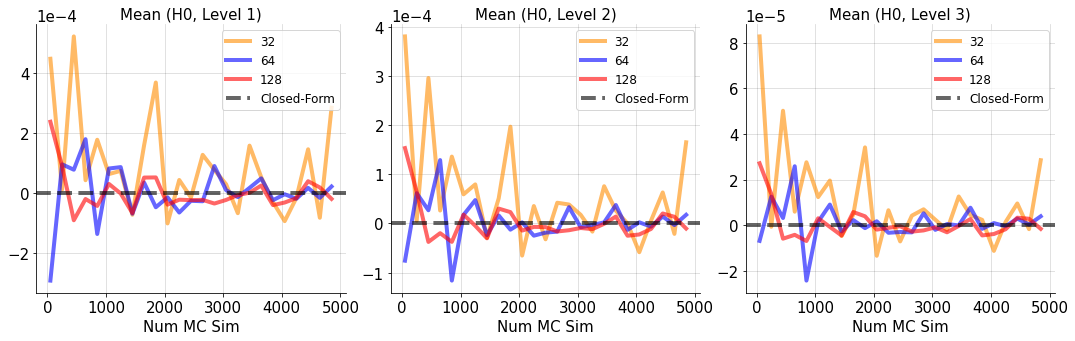

In [10]:
x_domain = list(range(50, 5000, 200))
domain_list = [32, 64, 128]
colors=['darkorange', 'blue', 'red', 'black']
keys = ['H0_mean_1', 'H0_mean_2', 'H0_mean_3']
alphas = [0.6, 0.6]
linewidths = [4, 4]
true_vals = [Exp_Gamma_1_ub(sig, sig, T=T), Exp_Gamma_2_ub(sig, sig, T=T), Exp_Gamma_3_ub(sig, sig, T=T)]
labels = [r'Closed-Form', r'Closed-Form', r'Closed-Form', r'Closed-Form', r'Closed-Form']
x_label = 'Num MC Sim'
titles = [r"Mean (H0, Level 1)", r"Mean (H0, Level 2)", r"Mean (H0, Level 3)"]
line_plot(x_domain, global_stats, domain_list, colors, titles, keys, alphas, linewidths, true_vals, labels, x_label,
          prefix='', scientific=False, svg=True, filename='ScaledBMImages/lvlmean_scaledbm_ub_H0.svg')
plt.show()

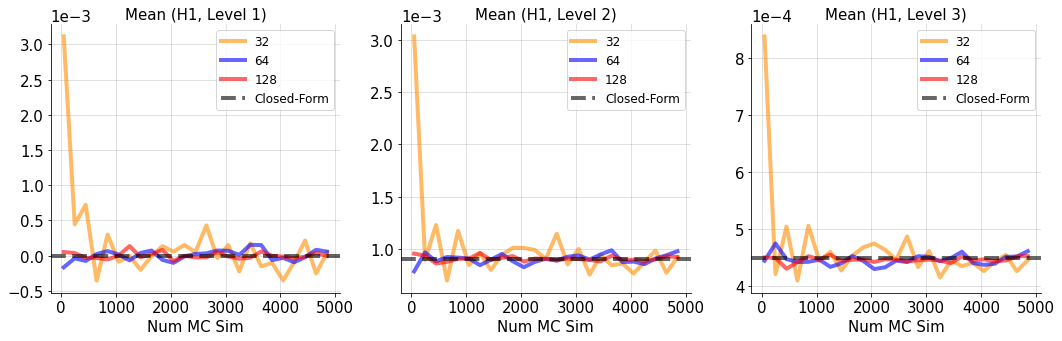

In [11]:
x_domain = list(range(50, 5000, 200))
domain_list = [32, 64, 128]
colors=['darkorange', 'blue', 'red', 'black']
keys = ['H1_mean_1', 'H1_mean_2', 'H1_mean_3']
alphas = [0.6, 0.6]
linewidths = [4, 4]
true_vals = [Exp_Gamma_1_ub(sig, beta, T=T), Exp_Gamma_2_ub(sig, beta,T=T), Exp_Gamma_3_ub(sig, beta,T=T)]
labels = ['Closed-Form', 'Closed-Form', 'Closed-Form']
x_label = 'Num MC Sim'
titles = [r"Mean (H1, Level 1)", r"Mean (H1, Level 2)", r"Mean (H1, Level 3)"]
line_plot(x_domain, global_stats, domain_list, colors, titles, keys, alphas, linewidths, true_vals, labels, x_label,
          prefix='', scientific=False, svg=True, filename='ScaledBMImages/lvlmean_scaledbm_ub_H1.svg')
plt.tight_layout()
plt.show()

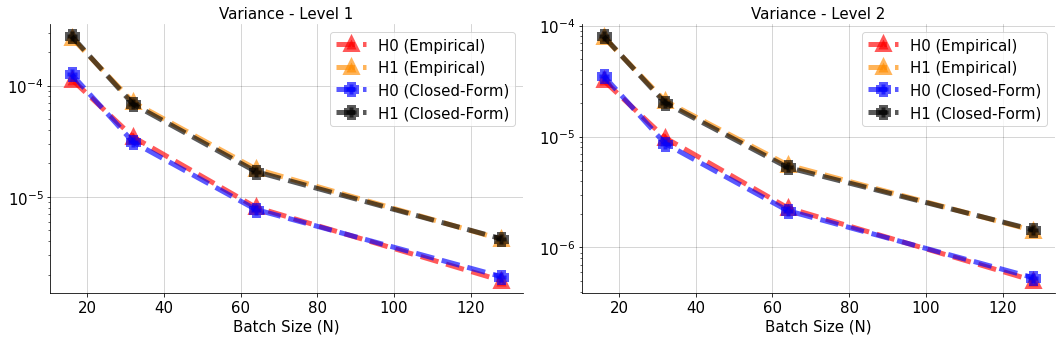

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
n_path_list = [16, 32, 64, 128]
ax[0].plot(n_path_list, [global_stats[n_paths]['H0_var_1'][-1] for n_paths in n_path_list], marker='^', color='red', linestyle='--', label='H0 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [global_stats[n_paths]['H1_var_1'][-1] for n_paths in n_path_list], marker='^', color='darkorange', linestyle='--', label='H1 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [Var_Gamma_1_ub(sig, sig, n_paths) for n_paths in n_path_list], marker='P', color='blue', linestyle='--', label=r'H0 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [Var_Gamma_1_ub(sig, beta, n_paths) for n_paths in n_path_list], marker='P', color='black', linestyle='--', label=r'H1 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)

ax[1].plot(n_path_list, [global_stats[n_paths]['H0_var_2'][-1] for n_paths in n_path_list], marker='^', color='red', linestyle='--', label='H0 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [global_stats[n_paths]['H1_var_2'][-1] for n_paths in n_path_list], marker='^', color='darkorange', linestyle='--', label='H1 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [Var_Gamma_2_ub(sig, sig, n_paths) for n_paths in n_path_list], marker='P', color='blue', linestyle='--', label=r'H0 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [Var_Gamma_2_ub(sig, beta, n_paths) for n_paths in n_path_list], marker='P', color='black', linestyle='--', label=r'H1 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)

ax[0].set_title(r"Variance - Level 1", fontsize=15)
ax[0].set_xlabel("Batch Size (N)", fontsize=15)

ax[1].set_title(r"Variance - Level 2", fontsize=15)
ax[1].set_xlabel("Batch Size (N)", fontsize=15)

for i in range(2):
    ax[i].legend(loc='best', fontsize=15)
    ax[i].grid(True, color='black', alpha=0.2)
    plt.setp(ax[i].get_xticklabels(), fontsize=15)
    plt.setp(ax[i].get_yticklabels(), fontsize=15)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
plt.tight_layout()
filename = 'ScaledBMImages/lvlvar_scaledbm_ub.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

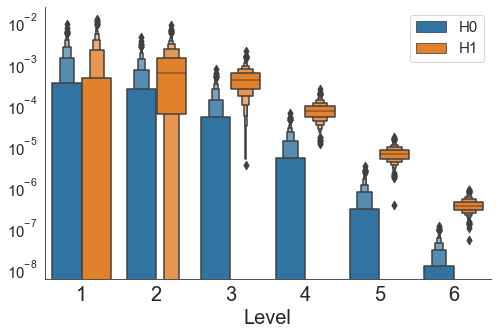

In [8]:
ks = [1, 2, 3, 4, 5, 6]

n_atoms = 1000
n_paths = 128

h0_Mk_vals, h1_Mk_vals = get_level_values(torch.multiply(torch.Tensor([1, 1]).to(device=device), h0_paths[:, :, :]), 
                                          torch.multiply(torch.Tensor([1, 1]).to(device=device), h1_paths[:, :, :]), 
                                          n_atoms, n_paths, ks, path_bank_size)
h0_Mk_vals = np.asarray(h0_Mk_vals)
h1_Mk_vals = np.asarray(h1_Mk_vals)

df_scaling = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 'MMD': np.concatenate((h0_Mk_vals.flatten(), h1_Mk_vals.flatten()))})
plot_dist_boxen(df_scaling, 'Level', 'MMD', hue='H', x_label='Level', filename=f'ScaledBMImages/scaledbm_level_contrib_noscaling.svg', svg=True, log_scale=True)

### Signal-to-Noise Ratio <a class="anchor" id="ub-ratio"></a>

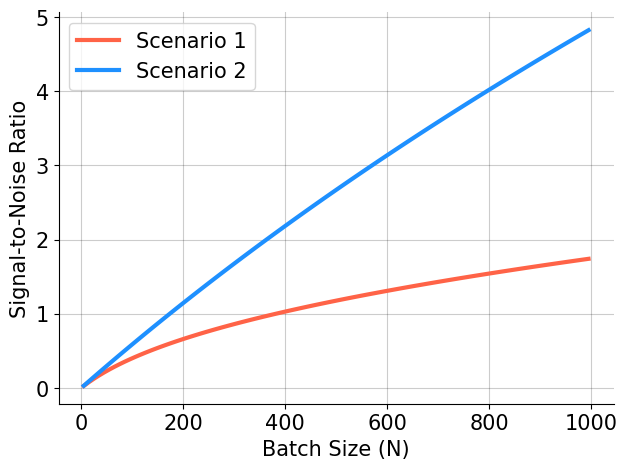

In [31]:
fig, ax = plt.subplots()
n_paths_list = range(5, 1000, 10)
ax.plot(n_paths_list, [Exp_Gamma_2_ub(0.9, 0.8)/np.sqrt(Var_Gamma_2_ub(0.9, 0.8, n_paths)) for n_paths in n_paths_list], label='Scenario 1', color='tomato', linewidth=3.0)
ax.plot(n_paths_list, [Exp_Gamma_2_ub(0.2, 0.1)/np.sqrt(Var_Gamma_2_ub(0.2, 0.1, n_paths)) for n_paths in n_paths_list], label='Scenario 2', color='dodgerblue', linewidth=3.0)
ax.legend(loc='best', fontsize=15)
ax.grid(True, color='black', alpha=0.2)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.set_ylabel(r"Signal-to-Noise Ratio", fontsize=15)
ax.set_xlabel("Batch Size (N)", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
filename = 'ScaledBMImages/signoiseratio_scaledbm_ub.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Without Scaling <a class="anchor" id="ub-ratio-no-scaling"></a>

In [ ]:
ks = [1, 2, 3, 4, 5, 6]

n_atoms = 1000

h0_Mk_vals_sr_global = np.zeros((6, len(ks), n_atoms))
h1_Mk_vals_sr_global = np.zeros((6, len(ks), n_atoms))


for i, n_paths in enumerate([32, 64, 128, 256, 512, 1000]):
    
    h0_Mk_vals_sr, h1_Mk_vals_sr = get_level_values(torch.multiply(torch.Tensor([1, 1]).to(device=device), h0_paths[:, :, :]), 
                                          torch.multiply(torch.Tensor([1, 1]).to(device=device), h1_paths[:, :, :]), 
                                          n_atoms, n_paths, ks, path_bank_size)
    h0_Mk_vals_sr = np.asarray(h0_Mk_vals_sr)
    h1_Mk_vals_sr = np.asarray(h1_Mk_vals_sr)
    
    h0_Mk_vals_sr_global[i, ...] = h0_Mk_vals_sr
    h1_Mk_vals_sr_global[i, ...] = h1_Mk_vals_sr

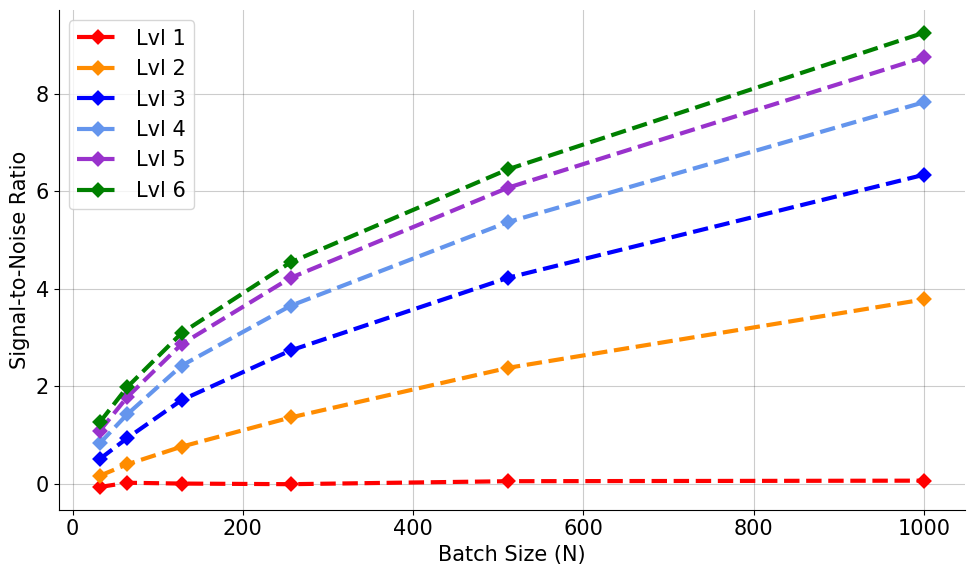

In [65]:
batch_sizes = [32, 64, 128, 256, 512, 1000]
colors = ['red', 'darkorange', 'blue', 'cornflowerblue', 'darkorchid', 'green']
fig, ax = plt.subplots(figsize=(10, 6))
for i, lvl in enumerate(ks):
    ax.plot(batch_sizes, 
               [np.mean(h1_Mk_vals_sr_global[j, i, ...])/np.std(h1_Mk_vals_sr_global[j, i, ...]) 
                for j in range(len(batch_sizes))], 
            label = f'Lvl {lvl}', 
            color=colors[i],
            marker='D',
            linestyle='--', 
            linewidth=3.0, 
            markersize=4.0, 
            markeredgewidth=4.0)
ax.legend(loc='best', fontsize=15)
ax.grid(True, color='black', alpha=0.2)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.set_ylabel(r"Signal-to-Noise Ratio", fontsize=15)
ax.set_xlabel("Batch Size (N)", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
filename = 'ScaledBMImages/signoiseratio_scaledbm_ub_lvls.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### With Scaling <a class="anchor" id="ub-ratio-with-scaling"></a>

In [ ]:
n_atoms = 1000

ks = [1, 2, 3, 4, 5, 6]


h0_Mk_vals_sr_global_scaling = np.zeros((6, len(ks), n_atoms))
h1_Mk_vals_sr_global_scaling = np.zeros((6, len(ks), n_atoms))

scaling = 3.0

for i, n_paths in enumerate([32, 64, 128, 256, 512, 1000]):
    
    h0_Mk_vals_sr_scaling, h1_Mk_vals_sr_scaling = get_level_values(torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
                                          torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]), 
                                          n_atoms, n_paths, ks, path_bank_size)
    h0_Mk_vals_sr_scaling = np.asarray(h0_Mk_vals_sr_scaling)
    h1_Mk_vals_sr_scaling = np.asarray(h1_Mk_vals_sr_scaling)
    
    h0_Mk_vals_sr_global_scaling[i, ...] = h0_Mk_vals_sr_scaling
    h1_Mk_vals_sr_global_scaling[i, ...] = h1_Mk_vals_sr_scaling

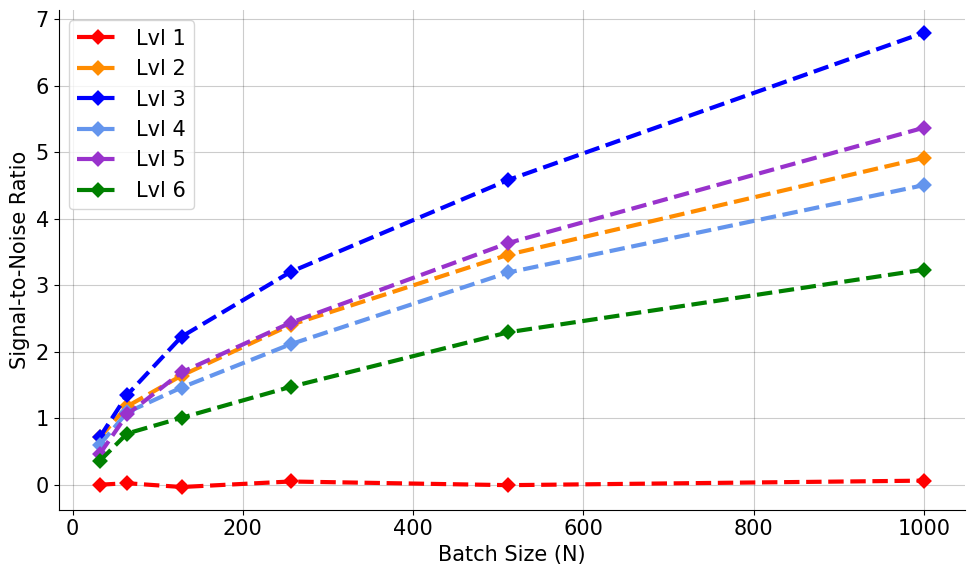

In [68]:
batch_sizes = [32, 64, 128, 256, 512, 1000]
colors = ['red', 'darkorange', 'blue', 'cornflowerblue', 'darkorchid', 'green']
fig, ax = plt.subplots(figsize=(10, 6))
for i, lvl in enumerate(ks):
    ax.plot(batch_sizes, 
               [np.mean(h1_Mk_vals_sr_global_scaling[j, i, ...])/np.std(h1_Mk_vals_sr_global_scaling[j, i, ...]) 
                for j in range(len(batch_sizes))], 
            label = f'Lvl {lvl}', 
            color=colors[i],
            marker='D',
            linestyle='--', 
            linewidth=3.0, 
            markersize=4.0, 
            markeredgewidth=4.0)
ax.legend(loc='best', fontsize=15)
ax.grid(True, color='black', alpha=0.2)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.set_ylabel(r"Signal-to-Noise Ratio", fontsize=15)
ax.set_xlabel("Batch Size (N)", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
filename = f'ScaledBMImages/signoiseratio_scaledbm_ub_lvls_scaling_{scaling}.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

## Biased Estimator  <a class="anchor" id="b"></a>

### Mean and Variance of Level Contributions <a class="anchor" id="b-stats"></a>

In [8]:
ks = [1, 2, 3]


global_stats_b = {}

for n_paths in [16, 32, 64, 128]:
    stats_dict = defaultdict(list)
    for n_atoms in tqdm(range(50, 5000, 200)):

        h0_Mk_vals, h1_Mk_vals = get_level_values(h0_paths, h1_paths, n_atoms, n_paths, ks, path_bank_size, verbose=False, unbiased=False)
        h0_Mk_vals = np.asarray(h0_Mk_vals)
        h1_Mk_vals = np.asarray(h1_Mk_vals)

        stats_dict['H0_mean_1'].append(np.mean(h0_Mk_vals[0, ...]))
        stats_dict['H0_mean_2'].append(np.mean(h0_Mk_vals[1, ...]))
        stats_dict['H0_mean_3'].append(np.mean(h0_Mk_vals[2, ...]))
        stats_dict['H0_var_1'].append(np.var(h0_Mk_vals[0, ...]))
        stats_dict['H0_var_2'].append(np.var(h0_Mk_vals[1, ...]))
        stats_dict['H0_var_3'].append(np.var(h0_Mk_vals[2, ...]))

        stats_dict['H1_mean_1'].append(np.mean(h1_Mk_vals[0, ...]))
        stats_dict['H1_mean_2'].append(np.mean(h1_Mk_vals[1, ...]))
        stats_dict['H1_mean_3'].append(np.mean(h1_Mk_vals[2, ...]))
        stats_dict['H1_var_1'].append(np.var(h1_Mk_vals[0, ...]))
        stats_dict['H1_var_2'].append(np.var(h1_Mk_vals[1, ...]))
        stats_dict['H1_var_3'].append(np.var(h1_Mk_vals[2, ...]))
    
    global_stats_b[n_paths] = stats_dict

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [48:38<00:00, 116.75s/it]


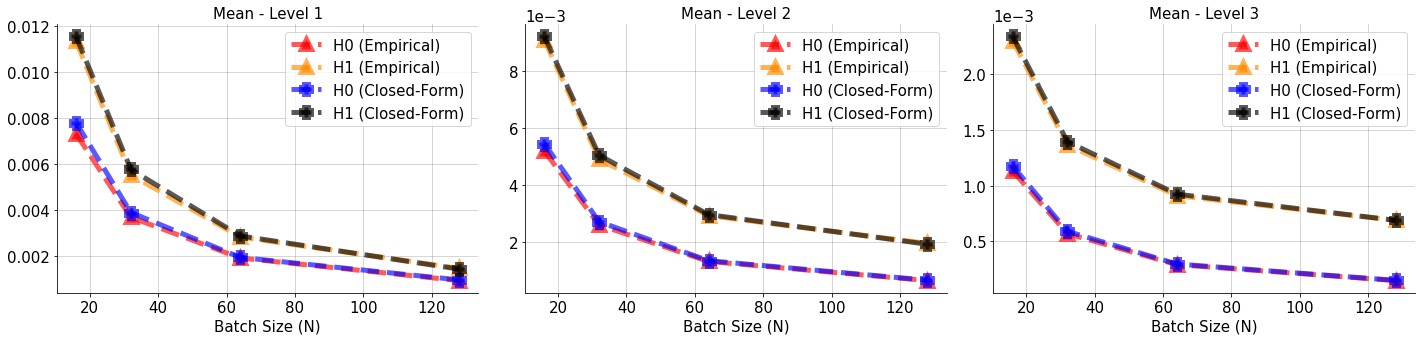

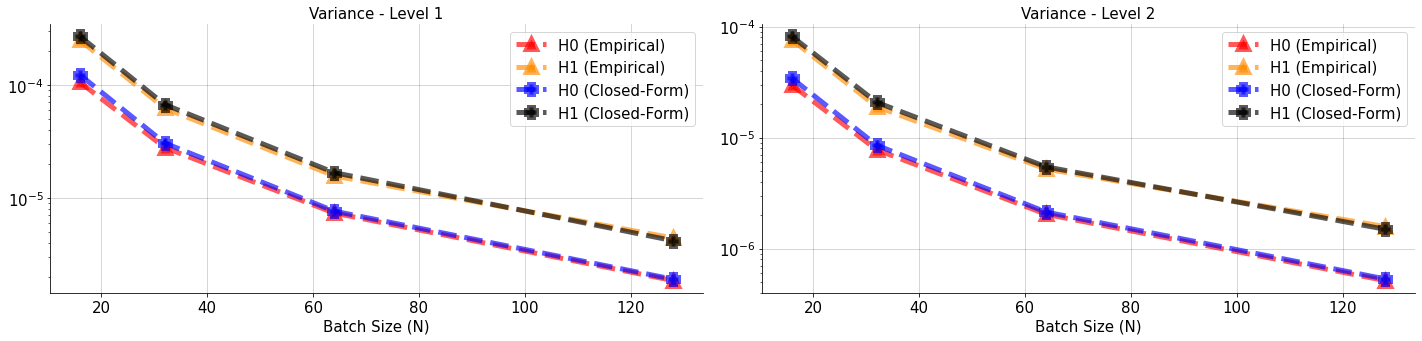

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
n_path_list = [16, 32, 64, 128]

ax[0].plot(n_path_list, [global_stats_b[n_paths]['H0_mean_1'][-1] for n_paths in n_path_list], marker='^', color='red', linestyle='--', label='H0 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [global_stats_b[n_paths]['H1_mean_1'][-1] for n_paths in n_path_list], marker='^', color='darkorange', linestyle='--', label='H1 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [Exp_Gamma_1_b(sig, sig, n_paths) for n_paths in n_path_list], marker='P', color='blue', linestyle='--', label=r'H0 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [Exp_Gamma_1_b(sig, beta, n_paths) for n_paths in n_path_list], marker='P', color='black', linestyle='--', label=r'H1 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [global_stats_b[n_paths]['H0_mean_2'][-1] for n_paths in n_path_list], marker='^', color='red', linestyle='--', label='H0 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [global_stats_b[n_paths]['H1_mean_2'][-1] for n_paths in n_path_list], marker='^', color='darkorange', linestyle='--', label='H1 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [Exp_Gamma_2_b(sig, sig, n_paths) for n_paths in n_path_list], marker='P', color='blue', linestyle='--', label=r'H0 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [Exp_Gamma_2_b(sig, beta, n_paths) for n_paths in n_path_list], marker='P', color='black', linestyle='--', label=r'H1 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[2].plot(n_path_list, [global_stats_b[n_paths]['H0_mean_3'][-1] for n_paths in n_path_list], marker='^', color='red', linestyle='--', label='H0 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[2].plot(n_path_list, [global_stats_b[n_paths]['H1_mean_3'][-1] for n_paths in n_path_list], marker='^', color='darkorange', linestyle='--', label='H1 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[2].plot(n_path_list, [Exp_Gamma_3_b(sig, sig, n_paths) for n_paths in n_path_list], marker='P', color='blue', linestyle='--', label=r'H0 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[2].plot(n_path_list, [Exp_Gamma_3_b(sig, beta, n_paths) for n_paths in n_path_list], marker='P', color='black', linestyle='--', label=r'H1 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)

ax[0].set_title(r"Mean - Level 1", fontsize=15)
ax[0].set_xlabel("Batch Size (N)", fontsize=15)
ax[1].set_title(r"Mean - Level 2", fontsize=15)
ax[1].set_xlabel("Batch Size (N)", fontsize=15)
ax[2].set_title(r"Mean - Level 3", fontsize=15)
ax[2].set_xlabel("Batch Size (N)", fontsize=15)

ax[1].yaxis.get_offset_text().set_fontsize(15)
ax[2].yaxis.get_offset_text().set_fontsize(15)

for i in range(3):
    ax[i].legend(loc='best', fontsize=15)
    ax[i].grid(True, color='black', alpha=0.2)
    plt.setp(ax[i].get_xticklabels(), fontsize=15)
    plt.setp(ax[i].get_yticklabels(), fontsize=15)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
plt.setp(ax[0].get_xticklabels(), fontsize=15)
plt.setp(ax[0].get_yticklabels(), fontsize=15)
ax[1].ticklabel_format(axis='y', scilimits=[-3, 3])
plt.setp(ax[1].get_xticklabels(), fontsize=15)
plt.setp(ax[1].get_yticklabels(), fontsize=15)
ax[2].ticklabel_format(axis='y', scilimits=[-3, 3])
plt.setp(ax[2].get_xticklabels(), fontsize=15)
plt.setp(ax[2].get_yticklabels(), fontsize=15)
plt.tight_layout()
filename = 'ScaledBMImages/lvlvarmean_scaledbm_b_mean.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].plot(n_path_list, [global_stats_b[n_paths]['H0_var_1'][-1] for n_paths in n_path_list], marker='^', color='red', linestyle='--', label='H0 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [global_stats_b[n_paths]['H1_var_1'][-1] for n_paths in n_path_list], marker='^', color='darkorange', linestyle='--', label='H1 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [Var_Gamma_1_b(sig, sig, n_paths) for n_paths in n_path_list], marker='P', color='blue', linestyle='--', label=r'H0 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].plot(n_path_list, [Var_Gamma_1_b(sig, beta, n_paths) for n_paths in n_path_list], marker='P', color='black', linestyle='--', label=r'H1 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [global_stats_b[n_paths]['H0_var_2'][-1] for n_paths in n_path_list], marker='^', color='red', linestyle='--', label='H0 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [global_stats_b[n_paths]['H1_var_2'][-1] for n_paths in n_path_list], marker='^', color='darkorange', linestyle='--', label='H1 (Empirical)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [Var_Gamma_2_b(sig, sig, n_paths) for n_paths in n_path_list], marker='P', color='blue', linestyle='--', label=r'H0 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[1].plot(n_path_list, [Var_Gamma_2_b(sig, beta, n_paths) for n_paths in n_path_list], marker='P', color='black', linestyle='--', label=r'H1 (Closed-Form)', alpha=0.65, linewidth=5.0, markersize=10.0, markeredgewidth=5.0)
ax[0].set_title(r"Variance - Level 1", fontsize=15)
ax[0].set_xlabel("Batch Size (N)", fontsize=15)
ax[1].set_title(r"Variance - Level 2", fontsize=15)
ax[1].set_xlabel("Batch Size (N)", fontsize=15)

for i in range(2):
    ax[i].legend(loc='best', fontsize=15)
    ax[i].grid(True, color='black', alpha=0.2)
    plt.setp(ax[i].get_xticklabels(), fontsize=15)
    plt.setp(ax[i].get_yticklabels(), fontsize=15)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
ax[0].set_yscale('log')
ax[1].set_yscale('log')
plt.tight_layout()
filename = 'ScaledBMImages/lvlvarmean_scaledbm_b_var.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

In [15]:
n_paths_list = range(5, 128, 10)
sig_noise_dict = defaultdict(list)
sig_noise_dict_b = defaultdict(list)
for n_paths in tqdm(n_paths_list):
    h0_Mk_vals_ub, h1_Mk_vals_ub = get_level_values(h0_paths, h1_paths, 1000, n_paths, [3, 4], path_bank_size, verbose=False, unbiased=True)
    h1_Mk_vals_ub = np.asarray(h1_Mk_vals_ub)
    sig_noise_dict[f'3'].append(np.mean(h1_Mk_vals_ub[0, ...])/np.std(h1_Mk_vals_ub[0, ...]))
    sig_noise_dict[f'4'].append(np.mean(h1_Mk_vals_ub[1, ...])/np.std(h1_Mk_vals_ub[1, ...]))
    
    h0_Mk_vals_b, h1_Mk_vals_b = get_level_values(h0_paths, h1_paths, 1000, n_paths, [3, 4], path_bank_size, verbose=False, unbiased=False)
    h1_Mk_vals_b = np.asarray(h1_Mk_vals_b)
    sig_noise_dict_b[f'3'].append(np.mean(h1_Mk_vals_b[0, ...])/np.std(h1_Mk_vals_b[0, ...]))
    sig_noise_dict_b[f'4'].append(np.mean(h1_Mk_vals_b[1, ...])/np.std(h1_Mk_vals_b[1, ...]))

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [16:23<00:00, 75.66s/it]


### Signal-to-Noise Ratio Comparison with Unbiased Estimator <a class="anchor" id="b-ratio"></a>

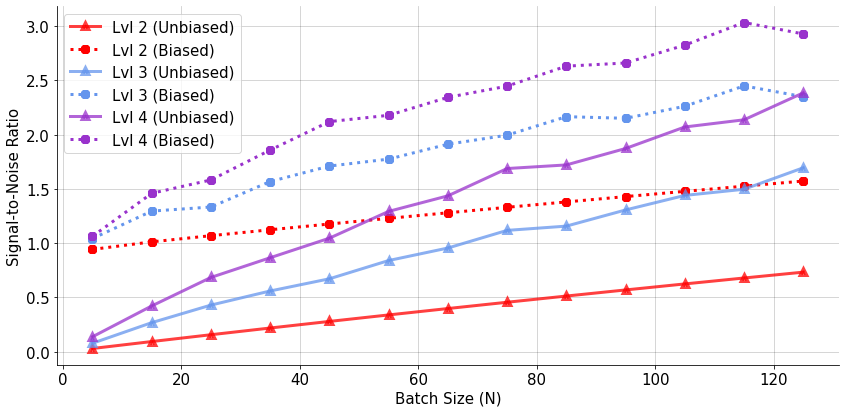

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(n_paths_list, [Exp_Gamma_2_ub(sig, beta)/np.sqrt(Var_Gamma_2_ub(sig, beta, n_paths)) for n_paths in n_paths_list], label='Lvl 2 (Unbiased)', color='red', alpha=0.75, linewidth=3.0, marker='^', markersize=4.5, markeredgewidth=4.5)
ax.plot(n_paths_list, [Exp_Gamma_2_b(sig, beta, n_paths)/np.sqrt(Var_Gamma_2_b(sig, beta, n_paths)) for n_paths in n_paths_list], label='Lvl 2 (Biased)', color='red', linestyle=':', linewidth=3.0, marker='P', markersize=4.5, markeredgewidth=4.5)
ax.plot(n_paths_list, sig_noise_dict['3'], label='Lvl 3 (Unbiased)', color='cornflowerblue', alpha=0.75, linewidth=3.0, marker='^', markersize=4.5, markeredgewidth=4.5)
ax.plot(n_paths_list, sig_noise_dict_b['3'], label='Lvl 3 (Biased)', color='cornflowerblue', linestyle=':', linewidth=3.0, marker='P', markersize=4.5, markeredgewidth=4.5)
ax.plot(n_paths_list, sig_noise_dict['4'], label='Lvl 4 (Unbiased)', color='darkorchid', alpha=0.75, linewidth=3.0, marker='^', markersize=4.5, markeredgewidth=4.5)
ax.plot(n_paths_list, sig_noise_dict_b['4'], label='Lvl 4 (Biased)', color='darkorchid', linestyle=':', linewidth=3.0, marker='P', markersize=4.5, markeredgewidth=4.5)
ax.legend(loc='best', fontsize=15)
ax.grid(True, color='black', alpha=0.2)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.set_ylabel(r"Signal-to-Noise Ratio", fontsize=15)
ax.set_xlabel("Batch Size (N)", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
filename = 'ScaledBMImages/signoiseratio_scaledbm_ub_b.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()